## Visualize results of the linear model

1. LM for all features
2. Group features by channel
3. Coefficient plots

## Import libraries

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


## Set paths and variables

In [2]:
# Focusing on plate 3
plate <- "localhost230405150001"

# Set directories
input_dir <- "results"
output_fig_dir <- "figures"

# Path to file with LM coefficients to plot
lm_file <- file.path(input_dir, paste0(plate, "_linear_model_failing_DMSO_TGFRi.tsv"))

# Paths for each figure output
lm_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_DMSO_TGFRi.png"))
lm_group_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_DMSO_TGFRi_bygroup.png"))
lm_coef_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_DMSO_TGFRi_coefficients.png"))


## Clean and sort the data prior to plotting

In [3]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

print(dim(lm_df))
head(lm_df, 3)


[1] 555   5


feature,r2_score,cell_count_coef,DMSO_coef,TGFRi_coef
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cytoplasm_AreaShape_Area,0.039682658,-0.0008561618,0.08628560,-0.08628560
Cytoplasm_AreaShape_Compactness,0.010084559,-0.0002080500,0.07782163,-0.07782163
Cytoplasm_AreaShape_Eccentricity,0.002526429,-0.0001411710,-0.05866033,0.05866033


In [4]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

# Arrange by absolute value coefficient
# Split out components of feature name for visualization
lm_df <- lm_df %>%
    dplyr::arrange(desc(abs(DMSO_coef))) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2",
            "parameter3"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

lm_df$channel_cleaned <- dplyr::recode(lm_df$channel_cleaned,
    "Hoechst" = "Nucleus",
    "ER" = "ER",
    "Actin" = "Actin",
    "Mitochondria" = "Mito",
    "PM" = "PM",
    .default = "other",
    .missing = "other"
)

print(dim(lm_df))
head(lm_df, 3)


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 322 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 11, 12, 14, 16, 17, 18, 20, 21, 23, 24, 25, ...].”


[1] 555  13


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,r2_score,cell_count_coef,DMSO_coef,TGFRi_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Nuclei_Intensity_LowerQuartileIntensity_Hoechst,Nuclei,Intensity,LowerQuartileIntensity,Hoechst,NA,NA,NA,0.2213254,0.0006175770,-0.4320595,0.4320595,Nucleus
Cells_Intensity_IntegratedIntensityEdge_Actin,Cells,Intensity,IntegratedIntensityEdge,Actin,NA,NA,NA,0.1322185,0.0003386005,0.4124558,-0.4124558,Actin
Nuclei_Correlation_Correlation_Hoechst_PM,Nuclei,Correlation,Correlation,Hoechst,PM,NA,NA,0.1260612,-0.0002596397,-0.3996143,0.3996143,Nucleus


## Visualize linear modeling results

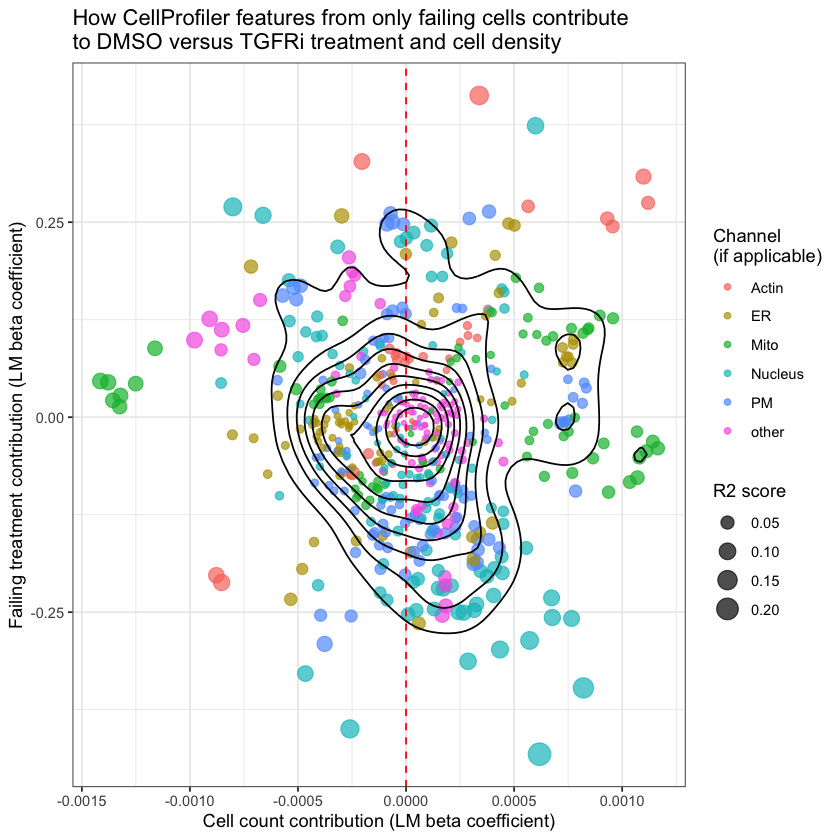

In [5]:
lm_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = DMSO_coef))
    + geom_point(aes(size = r2_score, color = channel_cleaned), alpha = 0.7)
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + geom_density2d(color="black", show.legend = FALSE)
    + theme_bw()
    + guides(
        color = guide_legend(title = "Channel\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Failing treatment contribution (LM beta coefficient)")
    + xlab("Cell count contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features from only failing cells contribute\nto DMSO versus TGFRi treatment and cell density")
)

# Output figure
ggsave(lm_fig, lm_fig_gg, dpi = 500, height = 6, width = 6)

lm_fig_gg


## Visualize LM based on channel

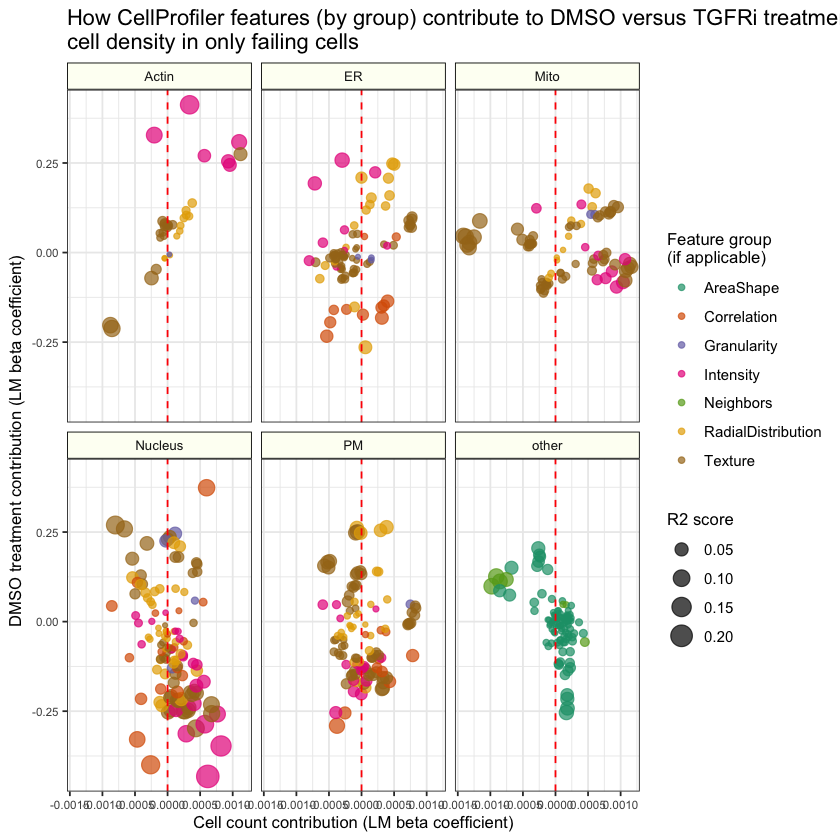

In [6]:
lm_group_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = DMSO_coef))
    + geom_point(aes(size = r2_score, color = feature_group), alpha = 0.7)
    + facet_wrap("~channel_cleaned")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + theme_bw()
    + guides(
        color = guide_legend(title = "Feature group\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("DMSO treatment contribution (LM beta coefficient)")
    + xlab("Cell count contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features (by group) contribute to DMSO versus TGFRi treatment and\ncell density in only failing cells")
    + scale_color_brewer(palette="Dark2")
    + theme(
        axis.text = element_text(size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_group_fig, lm_group_fig_gg, height = 6, width = 10, dpi = 500)

lm_group_fig_gg


## Visualize coefficients per LM

In [7]:
channels <- c(
    "Mitochondria" = "Mito",
    "Hoechst" = "DNA",
    "PM" = "PM",
    "ER" = "ER",
    "Actin" = "Actin"
)

lm_cleaned_df <- lm_df %>%
    dplyr::filter(channel %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = DMSO_coef, n = 1)

head(lm_cleaned_df, 2)


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,r2_score,cell_count_coef,DMSO_coef,TGFRi_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cells_Correlation_RWC_ER_PM,Cells,Correlation,RWC,ER,PM,NA,NA,0.029154519,2.154233e-05,-0.17329134,0.17329134,ER
Nuclei_Correlation_RWC_ER_PM,Nuclei,Correlation,RWC,ER,PM,NA,NA,0.001941983,4.489584e-05,0.04481839,-0.04481839,ER


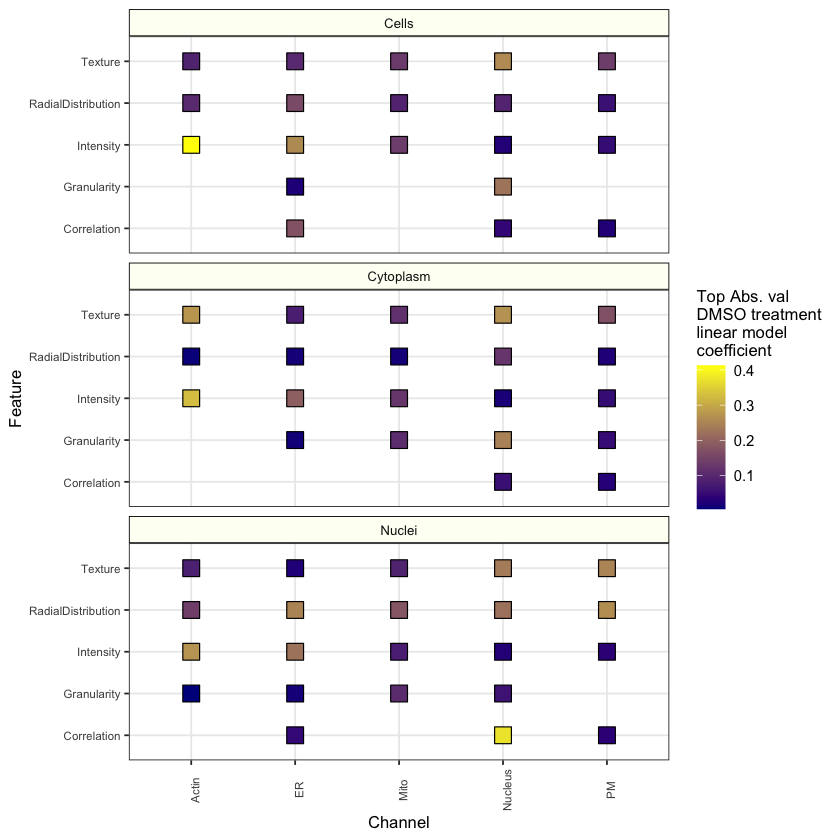

In [8]:
coef_gg <- (
    ggplot(lm_cleaned_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = abs(DMSO_coef)), pch = 22, size = 5)
    + facet_wrap("~compartment", ncol = 1)
    + theme_bw()
    + scale_fill_gradient(
        name="Top Abs. val\nDMSO treatment\nlinear model\ncoefficient",
        low = "darkblue",
        high = "yellow"
    )
    + xlab("Channel")
    + ylab("Feature")
    + theme(
        axis.text = element_text(size = 7),
        axis.text.x = element_text(angle = 90, size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_coef_fig, coef_gg, height = 5, width = 3.5, dpi = 500)

coef_gg
